In [33]:
import numpy as np
import cv2 as cv
from skimage.feature  import hog, Cascade
from skimage import exposure
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import dump, load
import time


<font color = red size = 5> Nhận dạng đối tượng trong ảnh</font>

In [34]:
dataset_path = "dataset"
datasetCrop_path = "datasetCrop"

Chuẩn hóa ảnh về ảnh xám sau đó cắt ảnh và lưu vào bộ dữ liệu mới


In [35]:
def normalization_img(path):
    BGRimg = cv.imread(path)
    if len(set(BGRimg[:,:,0].reshape(-1))) == 2:
        img = BGRimg[:,:,0]
    elif len(set(BGRimg[:,:,1].reshape(-1))) == 2:
        img = BGRimg[:,:,1]
    else:
        img = BGRimg[:,:,2]
    a, b = set(img.reshape(-1))
    count = np.bincount(img.reshape(-1))
    if count[a] < count[b]:
        min_count = a
        max_count = b
    else:
        min_count = b
        max_count = a
    img[img == min_count] = 255
    img[img == max_count] = 0
    return img

cắt ảnh lấy vật thể

In [36]:
def Crop_img(img):
    cols = []
    rows = []
    for i in  range(img.shape[0]):
        if 255 in img[i, :]:
            rows.append(i)
    for i in  range(img.shape[1]):
        if 255 in img[:, i]:
            cols.append(i)
    new_img = img[max(0, rows[0] - 10) : min(img.shape[0] - 1 , rows[-1] + 10), max(0, cols[0] - 10) : min(img.shape[1], cols[-1] + 10)]
    x, y, w, h = rows[0], cols[0], cols[-1] - cols[0], rows[-1] - rows[0] 
    return [x, y, w, h],new_img

Cắt ảnh và lưu vào tập dữ liệu mới


In [26]:
# for folder_shape in os.listdir(dataset_path):
#     folder_path = dataset_path + "/" + folder_shape
#     crop_folder_path = datasetCrop_path + "/" +  folder_shape
#     DetectObject_folder_path = DetectObject_path + "/" + folder_shape + ".txt"
#     object = []
#     for path in tqdm(os.listdir(folder_path), desc = folder_shape, ncols = 100):
#         img_path = folder_path + "/" + path
#         try:
#             new_img = normalization_img(img_path)
#             pos,new_img = Crop_img(new_img)
#             imwrite_path = crop_folder_path + "/" + path
#             cv.imwrite(imwrite_path, new_img)
#         except:
#             continue
#         object.append(pos)
#     object = np.array(object)
#     np.savetxt(DetectObject_folder_path, object, fmt = "%d", delimiter = ", ")
      

Triangle: 100%|███████████████████████████████████████████████| 10000/10000 [02:10<00:00, 76.57it/s]


Hiển thị ảnh sau khi chuẩn hóa

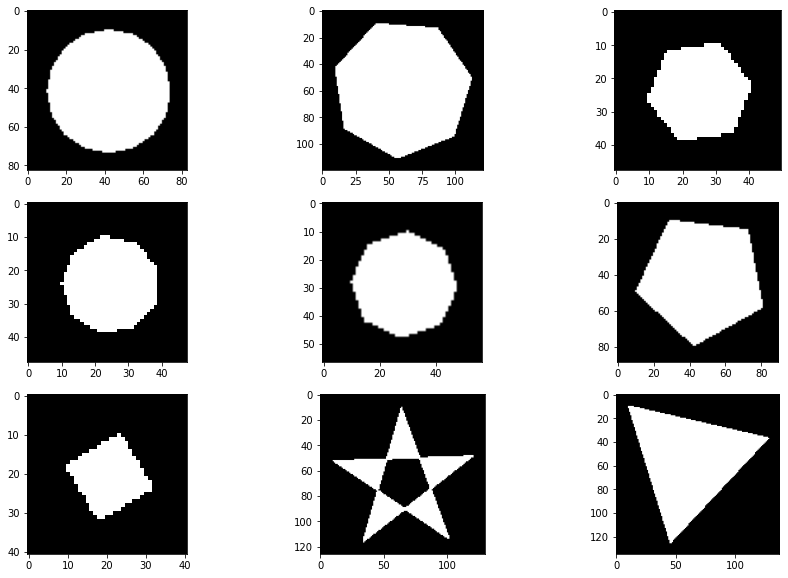

In [54]:
plt.subplots(3, 3, figsize=(15, 10))
for (i, folder_shape) in enumerate(os.listdir(dataset_path)):
    crop_folder_path = datasetCrop_path + "/" +  folder_shape
    plt.subplot(3,3,i + 1)
    for path in os.listdir(crop_folder_path):
        img_path = crop_folder_path + "/" + path
        img = cv.imread(img_path, 0)
        plt.imshow(img, "gray")
        break
  

kiểm tra xem cắt có đủ ảnh không

In [37]:
for folder_shape in os.listdir(dataset_path):
    folder_path = dataset_path + "/" + folder_shape
    crop_folder_path = datasetCrop_path + "/" +  folder_shape
    print(len(os.listdir(crop_folder_path)))


10000
10000
10000
10000
10000
10000
10000
10000
10000


Trích xuất đặc trưng HoG

In [52]:
def HOG_Skimage(img: np, cell_size = (8, 8), block_size = (2, 2), nbins = 9 ):
    fd, hog_image = hog(img, orientations = nbins, pixels_per_cell = cell_size,
                    cells_per_block = block_size, visualize=True, transform_sqrt=True )
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, out_range = (0, 255))
    return np.round(fd*1000), hog_image_rescaled

In [53]:
# min_shape = (200,200)
# for folder_shape in os.listdir(datasetCrop_path):
#     folder_path = datasetCrop_path + "/" + folder_shape
#     for path in tqdm(os.listdir(folder_path), desc = folder_shape, ncols = 100):
#         img_path = folder_path + "/" + path
#         img = cv.imread(img_path, 0)
#         min_shape = min(min_shape, img.shape)
        
# print(min_shape)

Triangle: 100%|████████████████████████████████████████████████| 9971/9971 [00:39<00:00, 250.19it/s]

(35, 35)


In [53]:
features = []
labels = []
new_shape = (32,32)
path_image = []
for folder_shape in os.listdir(datasetCrop_path):
    folder_path = datasetCrop_path + "/" + folder_shape
    for path in tqdm(os.listdir(folder_path), desc = folder_shape, ncols = 100):
        img_path = folder_path + "/" + path
        img = cv.imread(img_path,0)
        img = cv.resize(img, new_shape)
        fea, hog_image_rescaled = HOG_Skimage(img)
        features.append(fea)
        labels.append(path.split("_") [0])
        path_image.append(img_path)


Triangle: 100%|██████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.29it/s]


Hiển thị ảnh HoG

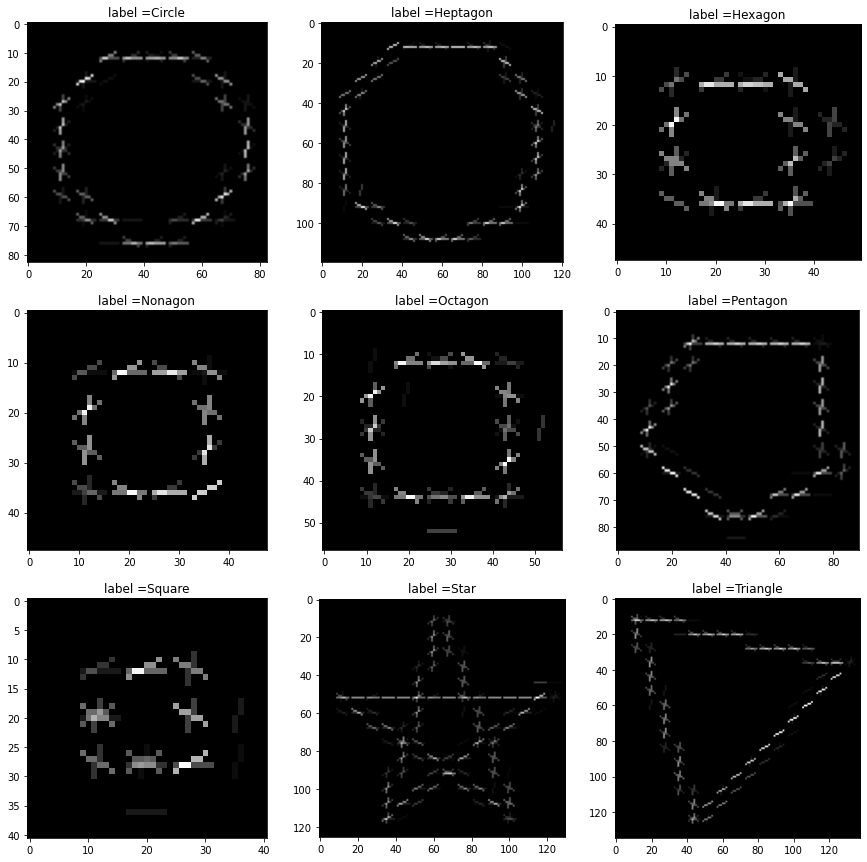

In [40]:
plt.subplots(3, 3, figsize=(15, 15))
new_shape = (32,32)

for (i, folder_shape) in enumerate(os.listdir(dataset_path)):
    crop_folder_path = datasetCrop_path + "/" +  folder_shape
    plt.subplot(3,3,i + 1)
    for path in os.listdir(crop_folder_path):
        img_path = crop_folder_path + "/" + path
        img = cv.imread(img_path, 0)
        # img = cv.resize(img, new_shape)
        fea, hog_image_rescaled = HOG_Skimage(img)
        plt.imshow(hog_image_rescaled, "gray")
        plt.title(f'label ={folder_shape}')
        break
        

chia dữ liệu

In [54]:
features = np.round(features)
labels = np.array(labels)
path_image = np.array(path_image)

In [56]:
np.savetxt("features.txt", features, fmt = "%d", delimiter = ", ")
np.savetxt("labels.txt", labels, fmt = "%s", delimiter = ", ")
np.savetxt("img_path.txt", path_image, fmt = "%s")

In [57]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 2)


sử dung SVM để nhận dạng đối tượng

In [58]:
svm_model = SVC(C = 10)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:",accuracy)

accuracy: 0.9873333333333333


Lưu model vào file xml

In [2]:
features = np.loadtxt("features.txt", dtype = np.uint32, delimiter = ", ")
labels = np.loadtxt("labels.txt", dtype = np.uint32)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 2)
svm_model = SVC(C = 10)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:",accuracy)

accuracy: 0.9873333333333333


In [61]:
dump(svm_model, "svm_model.xml")

['svm_model.xml']

<font color = red size = 5> Xác định vị trí của vật trong ảnh</font>

Lấy thông tin ảnh bằng sliding_window

In [112]:
def pyramid(image):
	# yield the original image
	yield image
 
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[0], x:x + windowSize[1]])    
   
def detectObject(img, svm_model: SVC, reSize = (32,32)):
    img = cv.resize(img, reSize)
    feature, _ = HOG_Skimage(img)
    feature = feature.reshape((1,-1))
    label = svm_model.predict(feature)
    return label
    
def draw_Object(img, x, y, w, h, label):
    cv.rectangle(img, (x,y), (x+w,y+h), color = (255,0,0), thickness = 5)
    cv.putText(img, label, (x+10,y - 10), cv.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2)
    
def HoG_detectMultiScale(image, svm_model, reSize = (32,32), thresh_prob = 0.6, minWindowSize = (32,32), maxWindowSize = (100,100), overlap = 8, scaleWindowSize = 1.2):
    
    windowSize = minWindowSize
    windowArray = []
    for img in pyramid(image):
        while  1:
            for (x, y, window) in sliding_window(img, stepSize=overlap, windowSize = windowSize):
            # # if the window does not meet our desired window size, ignore it
                if window.shape[0] != windowSize[0] or window.shape[1] != windowSize[1]:
                    continue
                
                label = detectObject(img, svm_model, reSize)
                if label != "unknown":
                    w = windowSize[1]
                    h = windowSize[0]
                    windowArray.append((x,y,w,h,label[0]))
            # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
            # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
            # WINDOW
            # since we do not have a classifier, we'll just draw the window
            windowSize = (round(windowSize[0]*scaleWindowSize),round(windowSize[1]*scaleWindowSize))
            if windowSize > maxWindowSize:
                break
    draw_img = image.copy()
    for (x,y,w,h,label_object) in windowArray:
        draw_Object(draw_img, x,y,w,h,label_object)
    

Lấy thông tin ảnh bằng đường viền

In [175]:
def detectObject(img, model, resize = (32,32)):
    img = cv.resize(img, resize)
    feature, _ = HOG_Skimage(img)
    feature = feature.reshape((1,-1))
    label = model.predict(feature)
    return label

def detectMultiScale(img,thresh_image, model):
    draw_img = img.copy()
    contours, _ = cv.findContours(thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for i in contours:
        (x,y,w,h) = cv.boundingRect(i)
        if 10 <= w <= 500 and 10 <= h <= 500:
            object = thresh_image[max(0,y-10) : min(y + h + 10, img.shape[0]), max(x - 10,0) : min( x + w + 10, img.shape[1])]
            # object = thresh_image[y - 10 : y + h + 10, x - 10 :x + w + 10]
            label = detectObject(object, model)
            cv.rectangle(draw_img, (x,y), (x+w,y+h), color = (255,0,0), thickness = 3)
            cv.putText(draw_img, label[0], (x+10,y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    plt.imshow(draw_img)


Xác định vị trí của vật

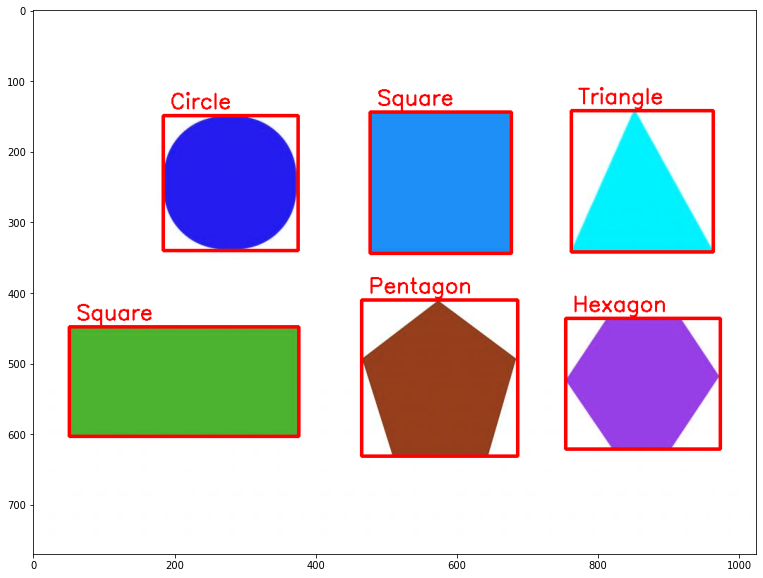

In [166]:
image = cv.imread("test.jpg")
svm_model = load("svm_model.xml")
GrayImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(GrayImage, 220, 255, 0)
plt.figure(figsize=(15,10))
detectMultiScale(image,thresh, svm_model)


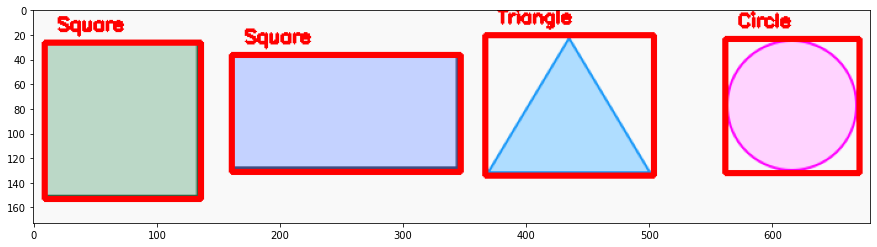

In [176]:
image = cv.imread("test2.webp")
svm_model = load("svm_model.xml")
GrayImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(GrayImage, 240, 255, 0)
plt.figure(figsize=(15,10))
detectMultiScale(image,thresh, svm_model)
